## 1D Simulations; Exact Hydrodynamics of Active Exclusion Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

Let's define some functions from Sections 2,4 of the paper: 
https://arxiv.org/pdf/2307.11673 


In [2]:
def d_s(rho: float):
    alpha = np.pi/2 - 1
    if rho<=1.0 and rho>=0.0:
        return (1-rho)*(1-alpha*rho + ((alpha*(2*alpha-1))/(2*alpha+1))*rho**2 )
    elif rho>= 1.0:
        print('density exceeding 1!!!!')
        return 0.0
    elif rho<=0.0:
        print('negative probs!!!!')
        return 0.0
    
def d_s_arr(rho_arr):
    alpha = np.pi/2 - 1
    return (1-rho_arr)*(1-alpha*rho_arr + ((alpha*(2*alpha-1))/(2*alpha+1))*rho_arr**2 )
    
def D(rho: float):
    return (1-d_s(rho))/rho

def s(rho: float):
    return (1-d_s(rho))/rho - 1

def s_arr(rho):
    return (np.ones(rho.shape)-d_s_arr(rho))/rho - np.ones(rho.shape)

def Q_diff(rho_1: float, rho_2: float):
    rho_avg = (rho_1 + rho_2 )/2
    alpha = np.pi/2 - 1
    beta = (alpha*(2*alpha-1))/(2*alpha+1)

    dQ_drho = ((alpha+1) - (alpha+beta)*rho_avg + beta*rho_avg**2)/(d_s(rho_avg))
    return dQ_drho*(rho_1 - rho_2)

def Q_diff_arr(rho_1, rho_2):
    rho_avg = (rho_1 + rho_2 )/2
    alpha = np.pi/2 - 1
    beta = (alpha*(2*alpha-1))/(2*alpha+1)

    dQ_drho = ((alpha+1) - (alpha+beta)*rho_avg + beta*rho_avg*rho_avg)/(d_s_arr(rho_avg))
    return dQ_drho*(rho_1 - rho_2)

def Q_diff_vectorized(rho_1, rho_2):
    rho_avg = (rho_1 + rho_2) / 2
    alpha = np.pi / 2 - 1
    beta = alpha * (2 * alpha - 1) / (2 * alpha + 1)

    # Calculate dQ_drho in a vectorized way
    dQ_drho = ((alpha + 1) - (alpha + beta) * rho_avg + beta * rho_avg**2) / d_s_arr(rho_avg)
    return dQ_drho * (rho_1 - rho_2)

In [183]:
def create_V_centered_hump(epsilon):
    center = 0.5
    d = 0.02

    def V_centered_hump(x):
        return np.where(
            np.abs(x - center) <= d,
            (1 + np.cos(np.pi / d * (x - center))) * epsilon,
            0.0
        )
    
    return V_centered_hump

def V_flat(x):
    return np.zeros(x.shape)

Next, some useful methods for calculating various functions and functionals of $f_{ijk}$

Next, we write a class for the field $f(\mathbf{x}, \theta)$:

In [177]:
class f:
    def __init__(self, N_x, N_theta, V, D_E=0.25, v_0=20.0, D_O=1.0, L_x=1.0) -> None:

        self.L_x = L_x
        self.N_x = N_x
        self.N_theta = N_theta
        self.delta_x = L_x/N_x
        self.delta_theta = 2*np.pi/N_theta
        self.t=0.0

        self.D_E = D_E
        self.v_0 = v_0
        self.D_O = D_O

        self.l_p = v_0/D_O
        self.l_D = np.sqrt(D_E/D_O)
        self.Pe = self.l_p/self.l_D
        self.l = self.l_D/L_x

        self.V = V
        self.V_diff = (self.V(self.delta_x * np.arange(1, self.N_x)) - self.V(self.delta_x * np.arange(self.N_x - 1))) / self.delta_x

        self.f = np.zeros((N_x, N_theta))
        self.calc_time = 0.0

    def rho(self):
        return self.delta_theta * np.sum(self.f, axis=1)
    
    def p1(self):
        e1 = np.array([np.cos(k*self.delta_theta) for k in range(self.N_theta)])
        return self.delta_theta * np.dot(self.f, e1)
    
    def S(self):
        rho_inst = self.rho()[1:-1]
        term1 = np.sum(np.array([(1-rho_i)*np.log(1-rho_i)*self.delta_x for rho_i in rho_inst]))
        term2 = np.sum(np.array([[f[i,k]*np.log(2*np.pi*f[i,k])*self.delta_x*self.delta_theta for k in range(self.N_theta)] for i in range(1, self.N_x-1)]))
        return term1+term2

    def U_x(self):
        p1_ = self.p1()
        rho_ = self.rho()
        log_f = np.log(self.f)

        diffusion = np.diff(log_f, axis=0) / self.delta_x
        exclusion = np.array([Q_diff_vectorized(rho_[1:], rho_[:-1]) / self.delta_x] * self.N_theta).T

        factor = (1 - rho_) / d_s_arr(rho_)
        factor_avg = 0.5 * (factor[:-1] + factor[1:])
        potential = (factor_avg * self.V_diff)[:, None] * np.ones(self.N_theta)

        s_rho = s_arr(rho_) / d_s_arr(rho_)  
        p1_s_rho = p1_ * s_rho  
        p1_avg = 0.5 * (p1_s_rho[1:] + p1_s_rho[:-1])
        cos_term = np.cos(np.arange(self.N_theta) * self.delta_theta)
        activity = 0.5 * (p1_avg[:, None] + cos_term)
        return (-self.D_E*( diffusion + exclusion + potential ) + self.v_0 * activity)
    
    def U_theta(self):
        log_f = np.log(self.f)
        angular_diffusion = (np.roll(log_f, shift=-1, axis=1) - log_f) / self.delta_theta
        return -self.D_O * angular_diffusion[:-1, :]
    
    def F_x(self, U_x):
        rho_ = self.rho()
        d_s_rho = d_s_arr(rho_) 
        f_next = np.roll(self.f, -1, axis=0)[:-1]
        d_s_rho_next = np.roll(d_s_rho, -1)[:-1] 
        
        d_s_avg = 0.5 * (d_s_rho + np.roll(d_s_rho, shift=-1))
        upwind_F = np.where(U_x >= 0, U_x * self.f[:-1], U_x * f_next)*d_s_avg[:-1][:, None]
        
        #upwind_F = np.where(U_x >= 0, U_x * self.f[:-1] * d_s_rho[:-1][:, None], U_x * f_next * d_s_rho_next[:, None])
        return upwind_F
    
    def F_theta(self, U_theta):
        f_shifted = np.roll(self.f, -1, axis=1)
        #upwind_F = np.where(U_theta >= 0, U_theta * self.f[:-1, :], U_theta * f_shifted[:-1, :])

        upwind_F = U_theta * (self.f[:-1, :]+f_shifted[:-1, :]) / 2
        return upwind_F

    def df_dt(self):
        
        U_x_ = self.U_x()
        U_theta_ = self.U_theta()
        
        a_x = np.max(np.abs(U_x_))
        a_theta = np.max(np.abs(U_theta_))
        
        F_x_ = self.F_x(U_x_)
        F_theta_ = self.F_theta(U_theta_)
        
        dF_x_dx = -(F_x_[1:self.N_x-1, :] - F_x_[:self.N_x-2, :]) / self.delta_x
        dF_theta_dtheta = -(F_theta_[1:self.N_x-1, :] - np.roll(F_theta_[1:self.N_x-1, :], +1, axis=1)) / self.delta_theta
        df_dt_ = dF_x_dx + dF_theta_dtheta

        return a_x, a_theta, df_dt_

    def update(self):
        self.f[0,:] = self.f[-2,:]
        self.f[-1,:] = self.f[1,:]
        
        a_x, a_theta, df_dt_ = self.df_dt()
        if a_x == 0.0:
            a_x = 0.1
        if a_theta == 0.0:
            a_theta = 0.1
        
        delta_t = min(self.delta_x/(a_x*6), self.delta_theta/(a_theta*6), 0.00001)

        self.f[1:-1, :] += df_dt_*delta_t
        self.t += delta_t

        return delta_t

    def evolve(self, N_t):
        self.t=0.0
        self.history_rho = []
        self.history_p1 = []
        self.history_direction = []

        for n in range(N_t):
            if n%100==0:
                self.history_rho.append( self.rho())
                self.history_p1.append(self.p1())
                self.history_direction.append(np.divide(self.p1(), self.rho()))       
            delta_t = self.update()
            self.t += delta_t
    
    def evolve_to_time(self, t, recording_steps):
        self.t=0.0
        self.history_rho = []
        self.history_p1 = []
        self.history_direction = []

        step = 0.0
        time_since_last_record = 0.0
        while self.t <= t:
            if time_since_last_record >= recording_steps:
                self.history_rho.append( self.rho())
                self.history_p1.append(self.p1())
                self.history_direction.append(np.divide(self.p1(), self.rho()))
                time_since_last_record = 0.0       
            
            delta_t = self.update()
            self.t += delta_t
            time_since_last_record += delta_t
    
    def plot_history_rho(self):
        plt.figure(figsize=(8, 6))
        plt.imshow(self.history_rho, cmap='coolwarm', aspect='auto')
        plt.colorbar()

        # Display the plot
        plt.title(f't = {self.t}')
        plt.show()
    
    def plot_history_dir(self, y_breaks, x_breaks):
        N_t = len(self.history_direction)

        x, y = np.meshgrid(np.linspace(0, self.N_x, int(self.N_x/x_breaks)),np.linspace(0, N_t, int(N_t/y_breaks))) 
        u = np.array(self.history_direction)[::y_breaks, 0::x_breaks]
        v = 0
        
        # Plotting Vector Field with QUIVER 
        plt.figure(figsize=(10,5))
        #plt.quiver(x, y, u, v, color='g') 
        plt.title(f't = {self.t}') 
        plt.grid() 
        #plt.imshow(p_history[:N_t], cmap='coolwarm', aspect='auto')#
        plt.imshow(self.history_rho[:N_t], cmap='coolwarm', aspect='auto', vmin=0.0, vmax=1.0)
        plt.colorbar()

    def set_random(self, phi, delta):
        self.f = np.copy(np.add((phi-delta/2)*np.ones((self.N_x, self.N_theta)), delta*np.random.rand(self.N_x, self.N_theta))*1/(2*np.pi))
    
    def set_sinusoidal(self):
        x = np.linspace(-np.pi, np.pi, self.N_x)  # Symmetric around 0
        sine_wave = np.sin(x*5)+2
        sin = np.tile(sine_wave, (self.N_theta, 1)).T
        self.f = np.copy(0.8*sin/(2*np.pi*3))

    def set_gaussian(self):
        x = np.linspace(-2, 2, self.N_x)  # Symmetric around 0
        mean = 0
        std_dev = 1.5
        gaussian_1d = np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
        gaussian_2d = np.tile(gaussian_1d, (self.N_theta, 1)).T
        self.f = 0.9*gaussian_2d/(2*np.pi)

    def rho_asymmetry(self, rho_):
        return np.sum(np.abs(rho_[1:-1] - np.flip(rho_[1:-1])))/np.sum(np.abs(rho_[1:-1] + np.flip(rho_[1:-1])))
    
    def phi(self):
        rho_ = self.rho()
        return np.sum(rho_[1:-1])*self.L_x/(self.N_x - 2)
    

In [227]:
N_x = 200


vapour = []
bulk = []
AS = []
epsilon_space = np.linspace(0.0, 3.0, 30)
for e in epsilon_space:
    vapour_concs = []
    bulk_concs = []
    asys = []
    for repeat in range(20):
        test_f = f(N_x=N_x, N_theta=6, V= create_V_centered_hump(epsilon=e) )
        test_f.set_random(phi=0.7, delta=0.1)

        t_finish = 5.0
        test_f.evolve_to_time(t=t_finish, recording_steps=t_finish/200)

        final_rho = test_f.history_rho[-1]

        asymmetry = test_f.rho_asymmetry(final_rho)
        bulk_conc = np.max(final_rho)
        vapour_conc = min(min(final_rho[0:95]), min(final_rho[105:200]))

        asys.append(asymmetry)
        bulk_concs.append(bulk_conc)
        vapour_concs.append(vapour_conc)
    
    vapour.append(vapour_concs)
    bulk.append(bulk_concs)
    AS.append(asys)

np.save('AS', np.array(AS))
np.save('vapour', np.array(vapour))
np.save('bulk', np.array(bulk))


<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_25800/3650135237.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Asymmetry at Steady State \n $\phi_0 = 0.7$ and Pe$=40$')


Text(0.5, 1.0, 'Asymmetry at Steady State \n $\\phi_0 = 0.7$ and Pe$=40$')

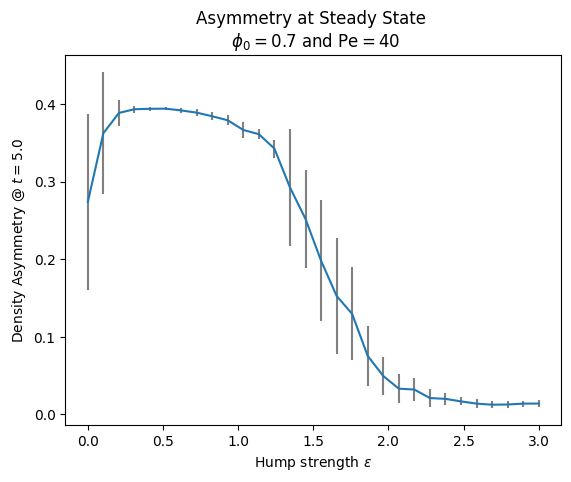

In [228]:
plt.errorbar(epsilon_space, np.mean(np.array(AS), axis=1), yerr=np.std(np.array(AS), axis=1), ecolor='grey')
#plt.plot(np.linspace(0.0, 3.0, 3), np.mean(np.array(AS), axis=1))
plt.xlabel(r'Hump strength $\epsilon$')
plt.ylabel(r'Density Asymmetry @ $t=5.0$')
plt.title('Asymmetry at Steady State \n $\phi_0 = 0.7$ and Pe$=40$')

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_25800/2718281239.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Phase Densities $\phi$ at Steady State \n $\phi_0 = 0.7$ and Pe$=40$')


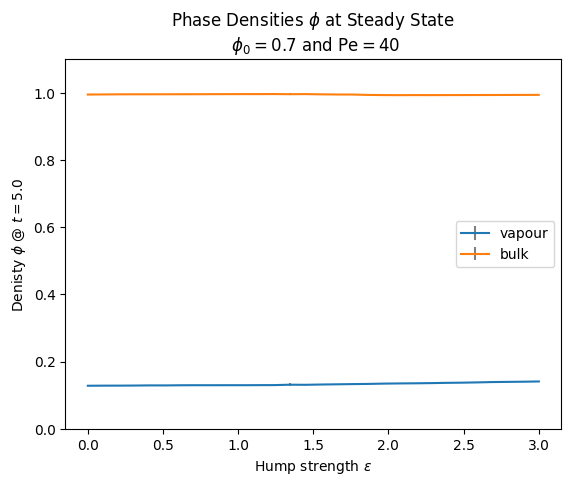

In [229]:
plt.errorbar(epsilon_space, np.mean(np.array(vapour), axis=1), yerr=np.std(np.array(vapour), axis=1), ecolor='grey', label='vapour')
plt.errorbar(epsilon_space, np.mean(np.array(bulk), axis=1), yerr=np.std(np.array(bulk), axis=1), ecolor='grey', label='bulk')
plt.legend()
plt.title('Phase Densities $\phi$ at Steady State \n $\phi_0 = 0.7$ and Pe$=40$')
#plt.plot(np.linspace(0.0, 3.0, 3), np.mean(np.array(AS), axis=1))
plt.xlabel(r'Hump strength $\epsilon$')
plt.ylabel(r'Denisty $\phi$ @ $t=5.0$')
plt.ylim(bottom=0.0, top=1.1)
plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
/var/folders/3q/bs71m3ns1kq5sjlny3rn8t5r0000gn/T/ipykernel_25800/3719908719.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f't = 3.0, $\epsilon=${epsilon}')


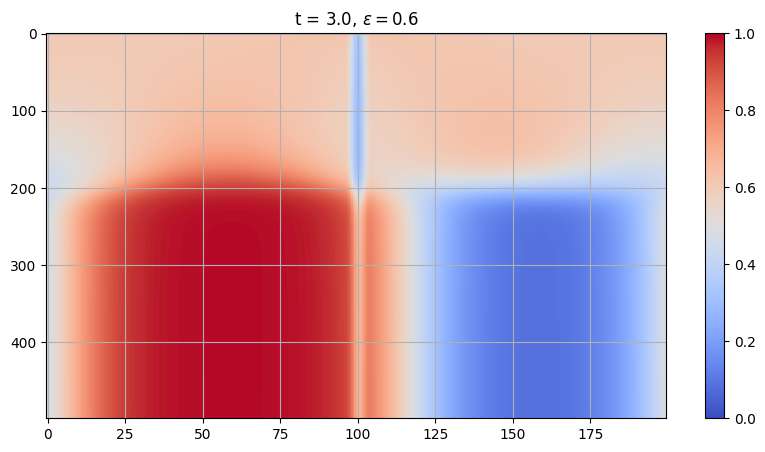

In [256]:
N_x = 200
epsilon=0.6
test_f = f(N_x=N_x, N_theta=6, V= create_V_centered_hump(epsilon=epsilon) )
test_f.set_random(phi=0.6, delta=0.1)
test_f.evolve_to_time(t=5.0, recording_steps=1.0/200)
test_f.plot_history_dir(y_breaks = 1, x_breaks=2)
plt.title(f't = 3.0, $\epsilon=${epsilon}')
plt.show() 

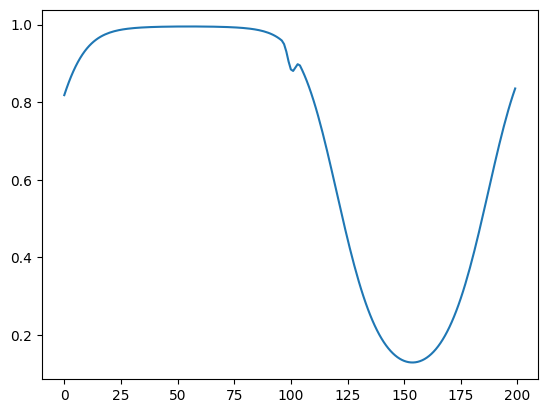

In [238]:
plt.plot(test_f.history_rho[-1])